<h1 align="center"><a href="https://github.com/sborquez/her2bdl"> Her2BDL</a> - Her2 Bayesian Deep Learning</h1>

<br>
<img src="images/utfsm.png" width="50%"/>

<h2 align="center">Exploratory Data Analysis</h2>

<center>
<i> Notebook created by Sebastián Bórquez G. - <a href="mailto://sebstian.borquez@sansano.usm.cl">sebastian.borquez@sansano.usm.cl</a> - utfsm - May 2021.</i>
</center>


# Setup Notebook


In [1]:
#!export HER2BDL_HOME="/home/sborquez/projects/her2bdl"
#!export HER2BDL_DATASETS="/home/sborquez/projects/her2bdl/datasets"
#!export HER2BDL_EXPERIMENTS="/home/sborquez/projects/her2bdl/experiments"

In [2]:
## (Option A) Colab Setup
# Connect to your `Google Drive` and install some dependencies.
try:
    raise NotImplementedError
    from google.colab import drive
    colab_ = True
    drive.mount('/content/drive')
    #!pip install git+https://github.com/sborquez/her2bdl\
## (Option B) Local Setup
# Run locally.
except:
    colab_ = False
    
# Adhoc modules
from extra import *

# Her2BDL package
#if is not installed run this line
HER2BDL_HOME=os.environ.get("HER2BDL_HOME")
%cd $HER2BDL_HOME

from her2bdl import *
%matplotlib inline

/home/asuka/projects/her2bdl


# Exploratory Data Analysis

Descripción y exploración del datasets, distribución de clases y ejemplos.


In [3]:
HER2BDL_DATASETS = Path(os.environ.get("HER2BDL_DATASETS")) 
WSI_FOLDER = HER2BDL_DATASETS/ "warwick"

## Warwick Her2 Scoring contest

### Descripción

WSIs are generally high resolution gigapixel images obtained by scanning the conventional glass slides. They are normally stored in pyramid structures containing several levels, each level has a different resolution. For visualization, the region-of-interest (ROI) from these images require specially designed libraries or tools. OpenSlide is one of the commonly used libraries that provides a simple interface to read WSIs.

### Source

- https://warwick.ac.uk/fac/sci/dcs/research/tia/her2contest/download/

- Qaiser, Talha, et al. "Her 2 challenge contest: a detailed assessment of automated her 2 scoring algorithms in whole slide images of breast cancer tissues." Histopathology 72.2 (2018): 227-238.
https://onlinelibrary.wiley.com/doi/epdf/10.1111/his.13333

- T. Qaiser, N.M. Rajpoot, "Learning Where to See: A Novel Attention Model for Automated Immunohistochemical Scoring", in IEEE Transactions on Medical Imaging, 2019. DOI: 10.1109/TMI.2019.2907049
https://ieeexplore.ieee.org/document/8672928


### Warwick Training Dataset

The training dataset consists of 52 WSIs with equally distributed cases for all 4 possible stages of HER2 scoring (0/ 1+/2+/3+).

The ground truth data for WSIs is provided in a spreadsheet containing the case number, HER2 score and percentage cells with complete membrane staining irrespective of intensity respectively.

In [4]:
source = WSI_FOLDER /'train'

train_dataset = get_dataset(source, include_ground_truth=True)
describe_dataset(train_dataset)
train_dataset.sample(5)

Dataset Info:
  size: 51
  columns: Index(['CaseNo', 'HeR2 SCORE', 'source', 'image_her2', 'image_he'], dtype='object')
  by class:
    Score 1: 13
    Score 2: 13
    Score 3: 13
    Score 0: 12


,CaseNo,HeR2 SCORE,source,image_her2,image_he
47,84,3,/home/asuka/projects/her2bdl/train/datasets/wa...,84_HER2.ndpi,84_HE.ndpi
31,52,0,/home/asuka/projects/her2bdl/train/datasets/wa...,52_HER2.ndpi,52_HE.ndpi
8,16,1,/home/asuka/projects/her2bdl/train/datasets/wa...,16_HER2.ndpi,16_HE.ndpi
10,19,3,/home/asuka/projects/her2bdl/train/datasets/wa...,19_HER2.ndpi,19_HE.ndpi
1,4,2,/home/asuka/projects/her2bdl/train/datasets/wa...,04_HER2.ndpi,04_HE.ndpi


### Warwick Testing Dataset 
The testing dataset contains 28 whole-slide-images (WSIs)

In [5]:
source = WSI_FOLDER /'test'

test_dataset = get_dataset(source, include_ground_truth=False)
describe_dataset(test_dataset, include_targets=False)
test_dataset.sample(1)

Dataset Info:
  size: 29
  columns: Index(['source', 'CaseNo', 'image_her2', 'image_he', 'HeR2 SCORE'], dtype='object')


,source,CaseNo,image_her2,image_he,HeR2 SCORE
9,/home/asuka/projects/her2bdl/train/datasets/wa...,28,28_HER2.ndpi,28_HE.ndpi,None


**Warwick Testing Dataset** doesn't have labels

## Training/Evaluation Splits

**Warwick Training Dataset** is divided into train/test 80/20 split using `prepare_dataset.py`.

In [6]:
train = aggregate_dataset(load_dataset(HER2BDL_DATASETS / "train.csv"))
test = aggregate_dataset(load_dataset(HER2BDL_DATASETS / "test.csv"))

/home/asuka/projects/her2bdl/her2bdl/data/dataset.py:224: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[col] = dataset[col].str.replace(*mapper)
/home/asuka/projects/her2bdl/her2bdl/data/dataset.py:224: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[col] = dataset[col].str.replace(*mapper)


### Class Balance

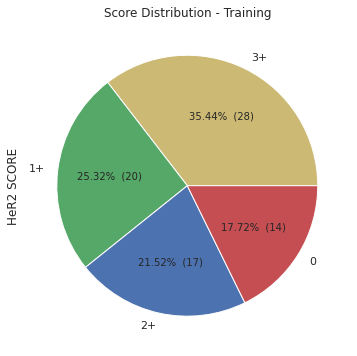

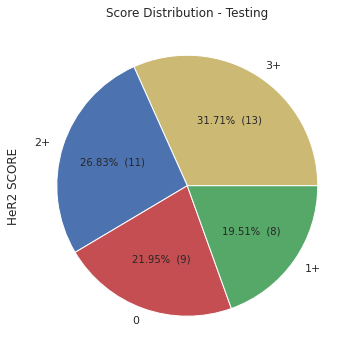

In [7]:
display_class_distribution(train, target=TARGET, target_labels=TARGET_LABELS, dataset_name="Training")
display_class_distribution(test, target=TARGET, target_labels=TARGET_LABELS, dataset_name="Testing")

## CrossValidation Splits

Training set is splitted into K-folds for hyperparameters optimization.

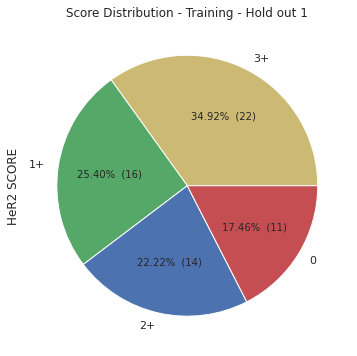

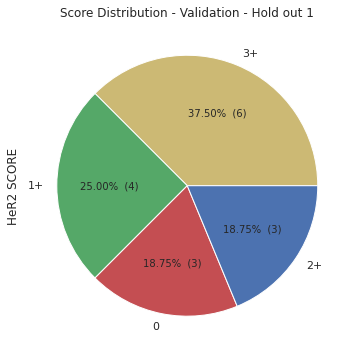

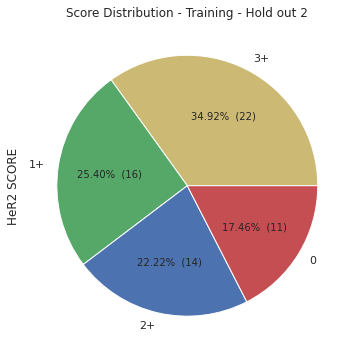

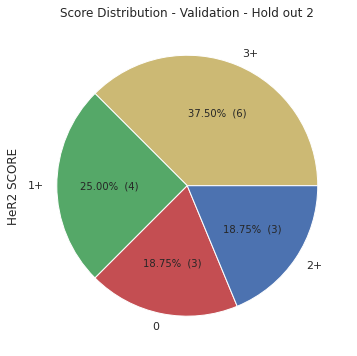

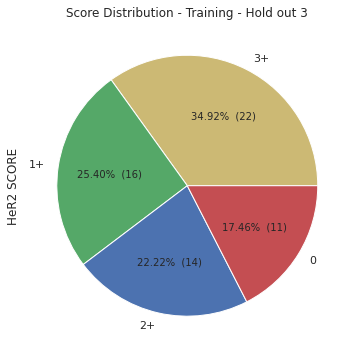

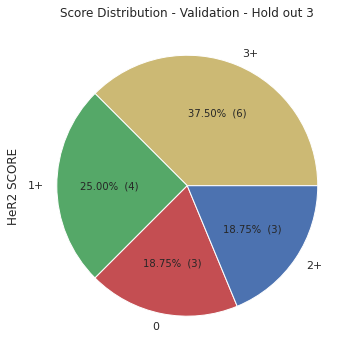

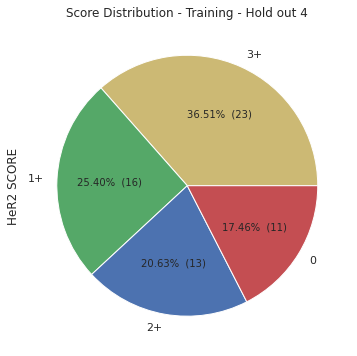

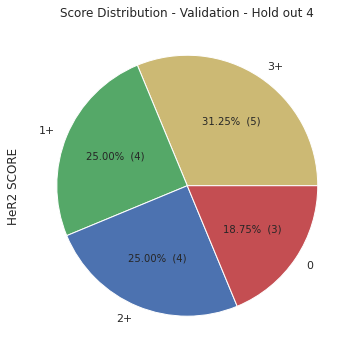

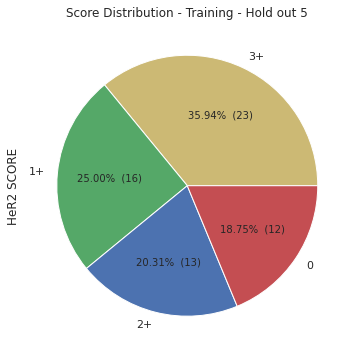

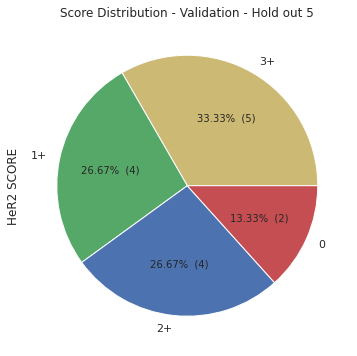

In [8]:
cv_splits = prepare_cv_splits(train, 5, seed=42)
for i, (tr, ts) in enumerate(cv_splits, start=1):
    display_class_distribution(tr, target=TARGET, target_labels=TARGET_LABELS, dataset_name=f"Training - Hold out {i}")
    display_class_distribution(ts, target=TARGET, target_labels=TARGET_LABELS, dataset_name=f"Validation - Hold out {i}")


## Training/Validation for Best parameters

The model with best performance in CV will be retrained with a new split of the training set. The divisiion of training/validation with a distribution 85%/15% it be used for earlystop and identify overfitting.

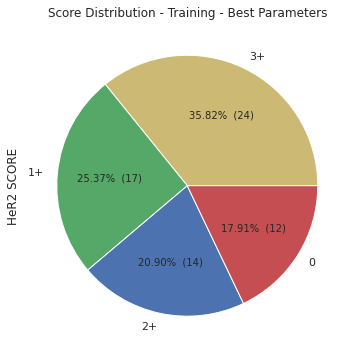

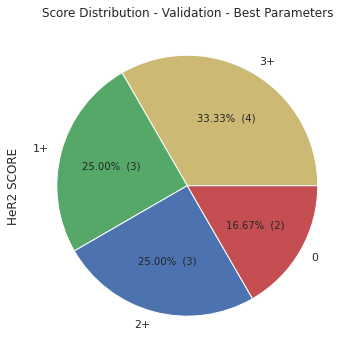

In [9]:
train_2, val_2 = split_dataset(train, validation_ratio=0.15, seed=42)
display_class_distribution(train_2, target=TARGET, target_labels=TARGET_LABELS, dataset_name=f"Training - Best Parameters")
display_class_distribution(val_2, target=TARGET, target_labels=TARGET_LABELS, dataset_name=f"Validation - Best Parameters");
#save_dataset(train_2, output_folder="./train/datasets/best_parameters", dataset_name=f"training")
#save_dataset(val_2, output_folder="./train/datasets/best_parameters", dataset_name=f"validation")

# WSI: Sample images

A whole-slide image is a digital representation of a microscopic slide, typically at a very high level of magnification such as 20x or 40x. As a result of this high magnification, whole slide images are typically very large in size. The maximum file size for a single whole-slide image in our training data set is 3.4 GB, with an average over 1 GB. [[source](https://developer.ibm.com/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/)]

We can use the [OpenSlide](https://openslide.org/api/python) project to read a variety of whole-slide image formats. This is a pyramidal, tiled format, where the massive slide is composed of a large number of constituent tiles.

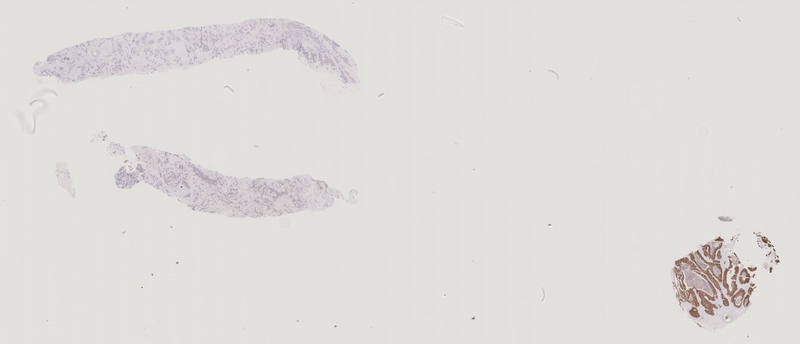

	level [0]: Downsampling 1.0 Size (135168, 58112)
	level [1]: Downsampling 2.0 Size (67584, 29056)
	level [2]: Downsampling 4.0 Size (33792, 14528)
	level [3]: Downsampling 8.0 Size (16896, 7264)
	level [4]: Downsampling 16.0 Size (8448, 3632)
	level [5]: Downsampling 32.0 Size (4224, 1816)
	level [6]: Downsampling 64.0 Size (2112, 908)
	level [7]: Downsampling 128.0 Size (1056, 454)
	level [8]: Downsampling 256.0 Size (528, 227)


In [10]:
samples = train_dataset.sample(1)
wsi_images = []
thumbnails = []
for _,sample in samples.iterrows():
    slide_path = str(sample["source"]/str(sample["CaseNo"]).zfill(2)/sample["image_her2"])
    her2_wsi = open_slide(slide_path)
    thumbnail = display_WSI_and_metadata(her2_wsi)
    wsi_images.append(her2_wsi)
    thumbnails.append(thumbnail)

## Size distribution

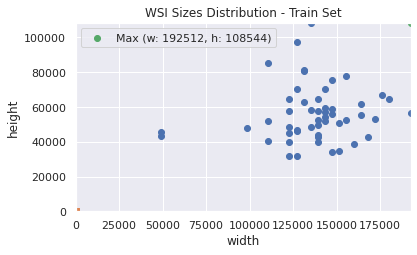

In [11]:
display_wsi_sizes_distribution(train_dataset, "Train Set")

## Otsu

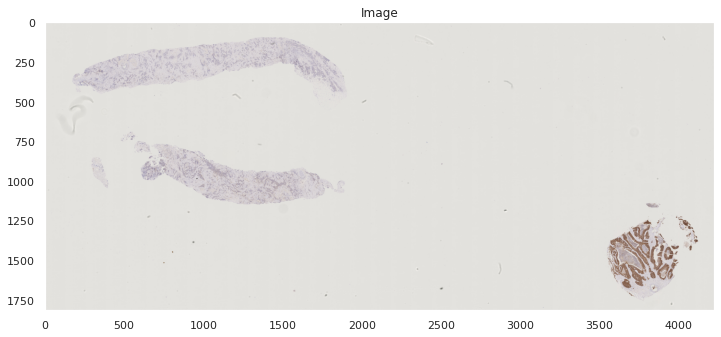

In [12]:
import cv2
size = her2_wsi.level_dimensions[5]
image = cv2.cvtColor(np.array(her2_wsi.get_thumbnail(size)),  cv2.COLOR_RGB2BGR)
plt.figure(figsize=(12, 6))
plt.title("Image")
plt.imshow(image[:,:,::-1], interpolation=None)
plt.grid(False)

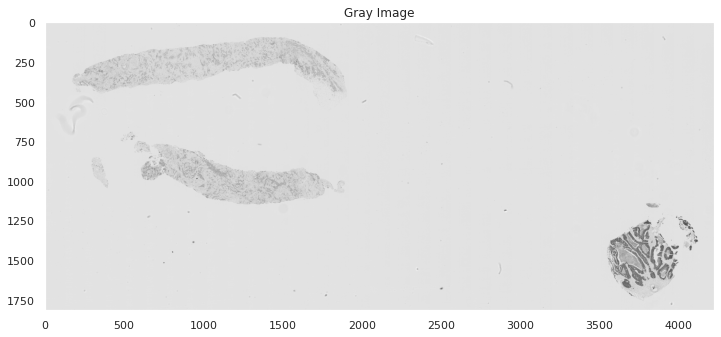

In [13]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12, 6))
plt.title("Gray Image")
plt.imshow(gray, interpolation=None, cmap="gray")
plt.grid(False)

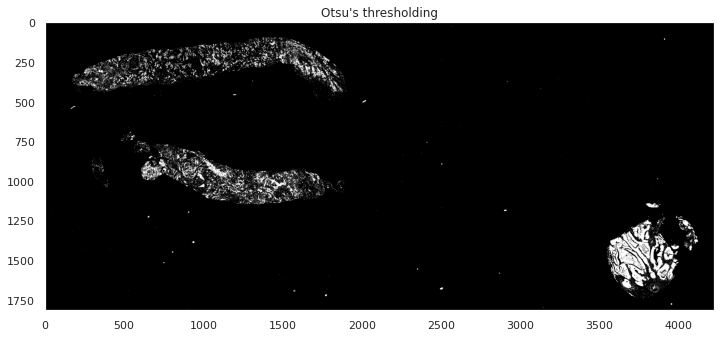

In [14]:
# Otsu's thresholding
ret2,th2 = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(12,6))
plt.title("Otsu's thresholding")
plt.imshow(th2, interpolation=None, cmap="binary")
plt.grid(False)

## OTSU with HSV


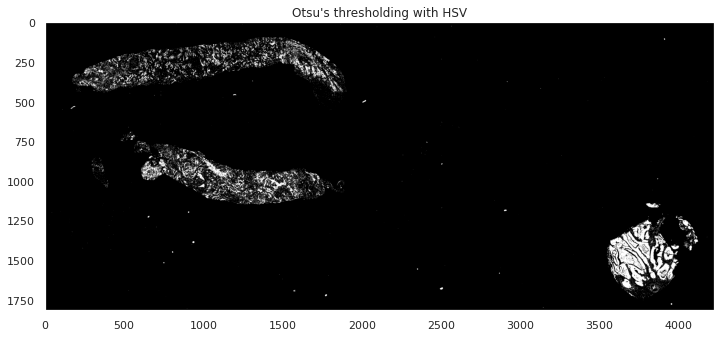

In [15]:
size = her2_wsi.level_dimensions[5]
image = cv2.cvtColor(np.array(her2_wsi.get_thumbnail(size)),  cv2.COLOR_RGB2HSV)

# 
ret2,th2 = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize=(12,6))
plt.title("Otsu's thresholding with HSV")
plt.imshow(th2, interpolation=None, cmap="binary")
plt.grid(False)

## Dataset Generator

Los generadores se encargan de alimentar a los modelos, generando los patches de imágenes etiquetados durante el entrenamiento.

In [16]:
train = aggregate_dataset(load_dataset(HER2BDL_DATASETS / "train.csv"))
test = aggregate_dataset(load_dataset(HER2BDL_DATASETS / "test.csv"))

/home/asuka/projects/her2bdl/her2bdl/data/dataset.py:224: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[col] = dataset[col].str.replace(*mapper)
/home/asuka/projects/her2bdl/her2bdl/data/dataset.py:224: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[col] = dataset[col].str.replace(*mapper)


### Grid Generator

Extract patches from a grid

100%|██████████| 35/35 [00:05<00:00,  6.44it/s]


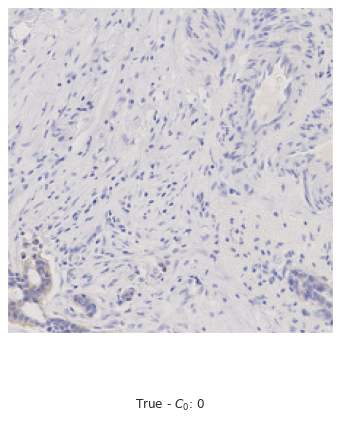

In [17]:
train_generator = GridPatchGenerator(train, 1, 3, (224, 224))
X_batch, y_batch = train_generator[0]
for xi, yi in zip(X_batch, y_batch):
    plot_sample(xi, yi.argmax())
    plt.show()

100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


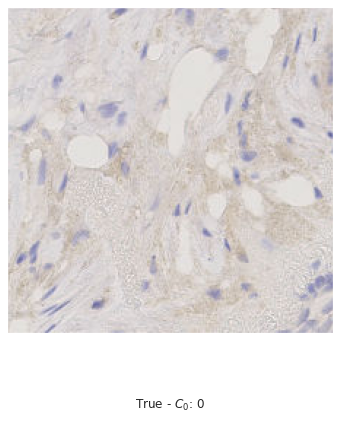

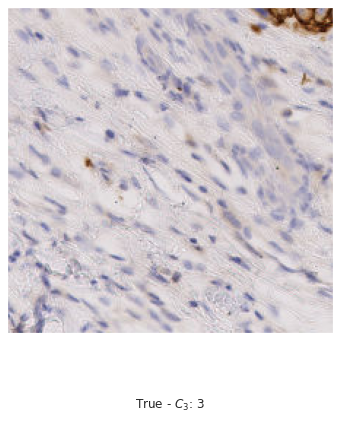

In [18]:
test_generator = GridPatchGenerator(test, 2, 2, (224, 224))
X_batch, y_batch = test_generator[0]
for xi, yi in zip(X_batch, y_batch):
    plot_sample(xi, yi.argmax())
    plt.show()

### MCPatchGenerator

Random patch samples from wsi image 

100%|██████████| 35/35 [00:42<00:00,  1.22s/it]


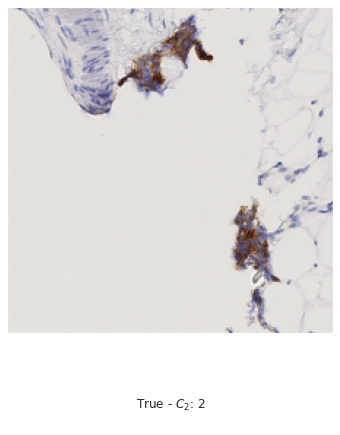

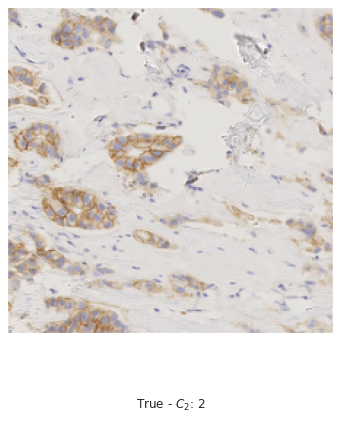

In [19]:
train_generator = MCPatchGenerator(train, 2, 3, (224, 224))
X_batch, y_batch = train_generator[0]
for xi, yi in zip(X_batch, y_batch):
    plot_sample(xi, yi.argmax())
    plt.show()

100%|██████████| 16/16 [00:31<00:00,  1.97s/it]


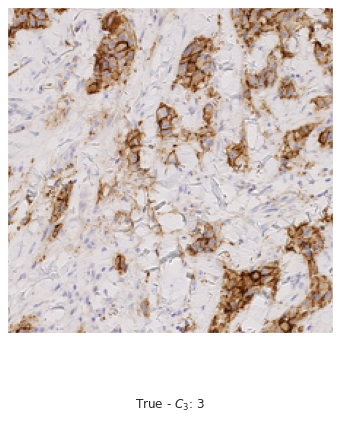

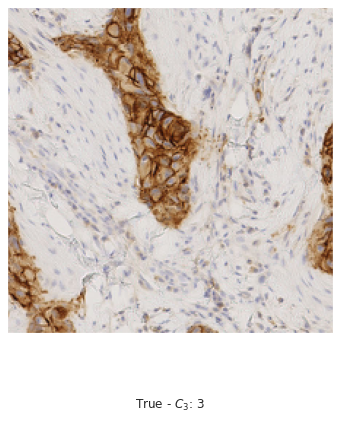

In [20]:
test_generator = MCPatchGenerator(test, 2, 3, (224, 224))
X_batch, y_batch = test_generator[3]
for xi, yi in zip(X_batch, y_batch):
    plot_sample(xi, yi.argmax())
    plt.show()